In [1]:
cd sample

/Users/zhoushijie/Desktop/sample


In [2]:
import pandas as pd

# Load datasets
# cities_df = pd.read_csv('./cities_test.csv')
# packages_df = pd.read_csv('./packages_test.csv')



In [3]:
!pip install gurobipy
from gurobipy import Model, GRB

In [4]:
from gurobipy import *

In [ ]:
import math

def euclidean_distance(x1, y1, x2, y2):
    return math.sqrt((x1 - x2)**2 + (y1 - y2)**2)


## Question 2 2)

## K = 2

In [9]:
# Load datasets
cities_df = pd.read_csv('./cities_small.csv')
packages_df = pd.read_csv('./packages_small.csv')

# Create a distance matrix
distances = {}
for i, row_i in cities_df.iterrows():
    for j, row_j in cities_df.iterrows():
        dist = euclidean_distance(row_i['lat'], row_i['lon'], row_j['lat'], row_j['lon'])
        distances[(int(row_i['id']), int(row_j['id']))] = dist

# Create a distance matrix
packages = {}
for i, row_i in packages_df.iterrows():
    packages[(row_i['origin'], row_i['destination'])] = row_i['packages']

for i in range(len(cities_df)):
    for j in range(len(cities_df)):
        if (i, j) not in packages:
            packages[(i, j)] = 0

print(distances)
print(packages)
print(len(distances))
print(len(packages))

{(0, 0): 0.0, (0, 1): 7.385265389230029, (0, 2): 38.15591593897656, (0, 3): 17.84376868899152, (0, 4): 5.408813028490058, (0, 5): 25.773889892811205, (0, 6): 41.49611653074913, (0, 7): 48.60553382145602, (0, 8): 39.29147706731318, (0, 9): 42.082014644191126, (0, 10): 34.74170158291984, (0, 11): 10.870017183439154, (0, 12): 28.091268550605463, (0, 13): 48.30461965636616, (0, 14): 30.044770767831277, (0, 15): 51.58763290393545, (0, 16): 11.176730921164692, (1, 0): 7.385265389230029, (1, 1): 0.0, (1, 2): 30.821370630396732, (1, 3): 11.140535810559616, (1, 4): 3.8947956806280275, (1, 5): 18.392032084910486, (1, 6): 34.214148100004024, (1, 7): 41.54601148997632, (1, 8): 32.38476390072753, (1, 9): 34.69721975018226, (1, 10): 27.874962861114362, (1, 11): 5.678534987172922, (1, 12): 20.7273715847404, (1, 13): 41.24228130761149, (1, 14): 23.63088834930368, (1, 15): 44.590700193329695, (1, 16): 4.106552016136462, (2, 0): 38.15591593897656, (2, 1): 30.821370630396732, (2, 2): 0.0, (2, 3): 21.1807

In [58]:
# K = 2



# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, k] * Y[k, j]
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j]

# Objective function with alpha = 0.75
alpha = 0.75
K = 2
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = sum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N))

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = sum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N))

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = sum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(sum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(sum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(sum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):

            # Wikj = Yik * Ykj
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] - 1)
        for m in range(N):
            for n in range(N):

                # Vimnj = Yim * Ymn * Ynj
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] - 2)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350575 rows, 89029 columns and 873562 nonzeros
Model fingerprint: 0xb9a0571b
Model has 8679 quadratic objective terms
Variable types: 0 continuous, 89029 integer (89029 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 58097 rows and 14505 columns (presolve time = 5s) ...
Presolve removed 58097 rows and 14505 columns (presolve time = 10s) ...
Presolve removed 309897 rows and 56939 columns
Presolve time: 12.91s
Presolved: 48831 rows, 40243 columns, 166269 nonzeros
Variable types: 0 continuous, 40243 integer (40243 binary)
Found heuristic solution: objective 2.592953e+07
Deterministic concurrent LP optimizer: primal and dual simplex
Showi

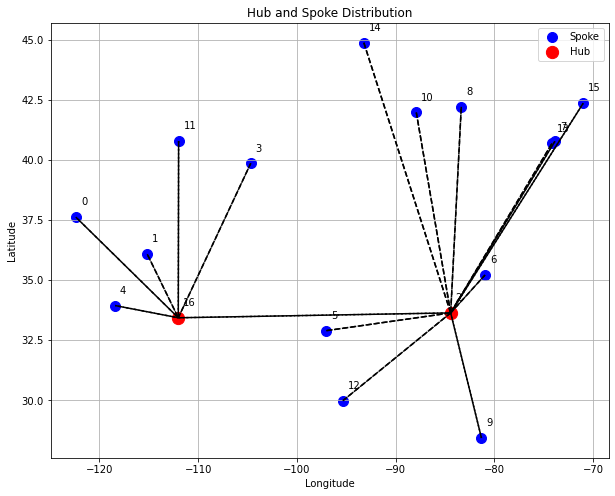

In [59]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()

## Question 2 3)

## K = 4

In [44]:
# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w") # Introduced for Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj)
U = model.addVars(N, N, N, vtype=GRB.BINARY, name="u") # Introduced for Xi * Xk * Xj
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

# Objective function with alpha = 0.75
alpha = 0.75
K = 4
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = quicksum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N) if i != j)

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = quicksum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j)

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = quicksum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(quicksum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(quicksum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(quicksum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):
            # Uikj = Xi * Xk * Xj
            model.addConstr(U[i, k, j] <= X[i])
            model.addConstr(U[i, k, j] <= X[k])
            model.addConstr(U[i, k, j] <= X[j])
            model.addConstr(U[i, k, j] >= X[i] + X[k] + X[j] - 2)

            # Wikj = Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj) = Y[i, k] * Y[k, j] * (1 - U[i, k, j])
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] <= 1 - U[i, k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] + (1 - U[i, k, j]) - 2)

        for m in range(N):
            for n in range(N):

                # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] <= 1 - X[i])
                model.addConstr(V[i, m, n, j] <= 1 - X[j])
                # model.addConstr(V[i, m, n, j] <= X[m])
                # model.addConstr(V[i, m, n, j] <= X[n])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350575 rows, 89029 columns and 873562 nonzeros
Model fingerprint: 0x156bee9e
Model has 8679 quadratic objective terms
Variable types: 0 continuous, 89029 integer (89029 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 4e+00]
Presolve removed 58097 rows and 14505 columns (presolve time = 5s) ...
Presolve removed 309897 rows and 56939 columns
Presolve time: 7.89s
Presolved: 48831 rows, 40243 columns, 166269 nonzeros
Variable types: 0 continuous, 40243 integer (40243 binary)
Found heuristic solution: objective 5.469177e+07
Found heuristic solution: objective 4.633963e+07
Found heuristic solution: objective 4.477403e+07
Deterministic concurrent LP optimizer: prim

  9489  3362 5260655.31   29  232 2.4770e+07 1442288.87  94.2%   155  207s
  9837  3375 5213069.11   29  584 2.4770e+07 1499718.49  93.9%   157  232s
  9918  3471 5844262.62   32  240 2.4770e+07 1526233.29  93.8%   158  236s
 10356  3761     cutoff   34      2.4770e+07 1712620.67  93.1%   159  240s
 12119  4216 2.2247e+07   31  330 2.4770e+07 2282903.59  90.8%   150  249s
 12930  4478 2.4762e+07   39  318 2.4770e+07 2486358.67  90.0%   147  253s
 13819  4751 infeasible   31      2.4770e+07 2649043.30  89.3%   145  258s
 14805  5066 2.1593e+07   40  298 2.4770e+07 2775197.85  88.8%   141  265s
 16007  5101 2.3367e+07   28  338 2.4770e+07 2995264.85  87.9%   139  270s
 16776  5302 6986741.61   33  280 2.4770e+07 3105425.20  87.5%   138  278s
 17301  5394     cutoff   29      2.4770e+07 3196668.20  87.1%   139  283s
 18013  5461 2.3130e+07   30  338 2.4770e+07 3340063.38  86.5%   139  288s
 18702  5484 2.1356e+07   35  306 2.4770e+07 3560194.02  85.6%   139  293s
 19242  5443 2.3437e+07  

In [45]:
if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Optimal Solution Found
X[0] = 0.0
X[1] = 0.0
X[2] = 0.0
X[3] = 0.0
X[4] = 0.0
X[5] = 0.0
X[6] = 1.0
X[7] = 0.0
X[8] = 0.0
X[9] = 0.0
X[10] = 0.0
X[11] = 1.0
X[12] = 1.0
X[13] = 0.0
X[14] = 1.0
X[15] = 0.0
X[16] = 0.0
Y[0,0] = 0.0
Y[0,1] = 0.0
Y[0,2] = 0.0
Y[0,3] = 0.0
Y[0,4] = 0.0
Y[0,5] = 0.0
Y[0,6] = 0.0
Y[0,7] = 0.0
Y[0,8] = 0.0
Y[0,9] = 0.0
Y[0,10] = 0.0
Y[0,11] = 1.0
Y[0,12] = 0.0
Y[0,13] = 0.0
Y[0,14] = 0.0
Y[0,15] = 0.0
Y[0,16] = 0.0
Y[1,0] = 0.0
Y[1,1] = 0.0
Y[1,2] = 0.0
Y[1,3] = 0.0
Y[1,4] = 0.0
Y[1,5] = 0.0
Y[1,6] = 0.0
Y[1,7] = 0.0
Y[1,8] = 0.0
Y[1,9] = 0.0
Y[1,10] = 0.0
Y[1,11] = 1.0
Y[1,12] = 0.0
Y[1,13] = 0.0
Y[1,14] = 0.0
Y[1,15] = 0.0
Y[1,16] = 0.0
Y[2,0] = 0.0
Y[2,1] = 0.0
Y[2,2] = 0.0
Y[2,3] = 0.0
Y[2,4] = 0.0
Y[2,5] = 0.0
Y[2,6] = 1.0
Y[2,7] = 0.0
Y[2,8] = 0.0
Y[2,9] = 0.0
Y[2,10] = 0.0
Y[2,11] = 0.0
Y[2,12] = 0.0
Y[2,13] = 0.0
Y[2,14] = 0.0
Y[2,15] = 0.0
Y[2,16] = 0.0
Y[3,0] = 0.0
Y[3,1] = 0.0
Y[3,2] = 0.0
Y[3,3] = 0.0
Y[3,4] = 0.0
Y[3,5] = 0.0
Y[3,6] = 0.0
Y[3,7] =

In [ ]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()

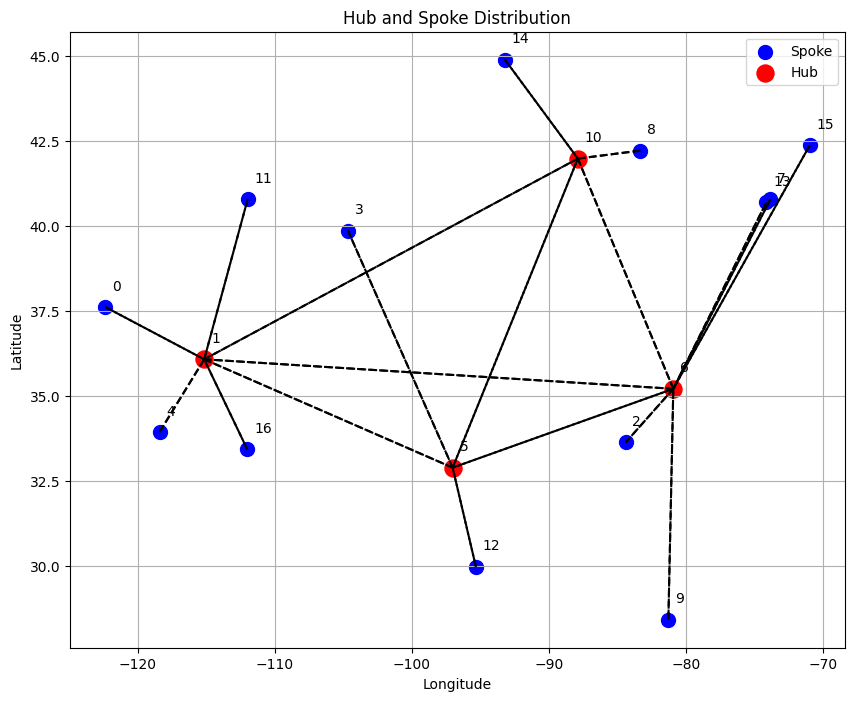

## K = 1

In [60]:
#K = 1


# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, k] * Y[k, j]
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="w")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j]

# Objective function with alpha = 0.75
alpha = 0.75
K = 1
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = sum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N))

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = sum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N))

# s-h-h-s
obj_3 = sum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense= GRB.MINIMIZE)

# Constraints
model.addConstr(sum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(sum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(sum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):

            # Wikj = Yik * Ykj
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] - 1)
        for m in range(N):
            for n in range(N):

                # Vimnj = Yim * Ymn * Ynj
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] - 2)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 350575 rows, 89029 columns and 873562 nonzeros
Model fingerprint: 0xd7689179
Model has 8679 quadratic objective terms
Variable types: 0 continuous, 89029 integer (89029 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 2e+00]
Presolve removed 58332 rows and 14505 columns (presolve time = 5s) ...
Presolve removed 58332 rows and 14505 columns (presolve time = 10s) ...
Presolve removed 58332 rows and 14505 columns (presolve time = 15s) ...
Presolve removed 58332 rows and 14505 columns (presolve time = 20s) ...
Presolve removed 58916 rows and 14599 columns (presolve time = 25s) ...
Presolve removed 251108 rows and 21540 columns (presolve time = 30s) ...
Presolve r

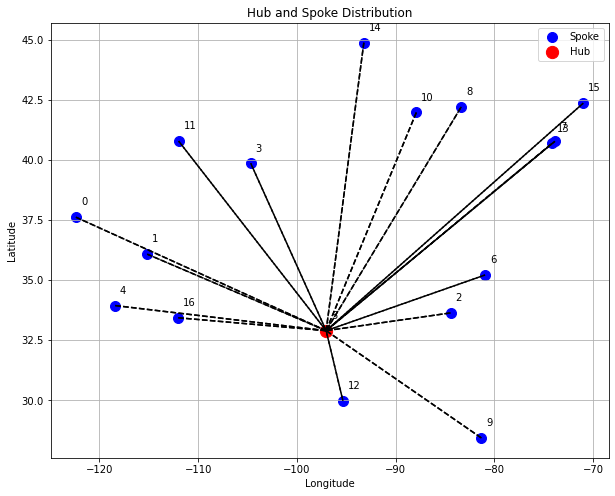

In [61]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()

## K = 6

In [ ]:
# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w") # Introduced for Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj)
U = model.addVars(N, N, N, vtype=GRB.BINARY, name="u") # Introduced for Xi * Xk * Xj
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

# Objective function with alpha = 0.75
alpha = 0.75
K = 6
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = quicksum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N) if i != j)

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = quicksum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j)

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = quicksum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(quicksum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(quicksum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(quicksum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):
            # Uikj = Xi * Xk * Xj
            model.addConstr(U[i, k, j] <= X[i])
            model.addConstr(U[i, k, j] <= X[k])
            model.addConstr(U[i, k, j] <= X[j])
            model.addConstr(U[i, k, j] >= X[i] + X[k] + X[j] - 2)

            # Wikj = Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj) = Y[i, k] * Y[k, j] * (1 - U[i, k, j])
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] <= 1 - U[i, k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] + (1 - U[i, k, j]) - 2)

        for m in range(N):
            for n in range(N):

                # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] <= 1 - X[i])
                model.addConstr(V[i, m, n, j] <= 1 - X[j])
                # model.addConstr(V[i, m, n, j] <= X[m])
                # model.addConstr(V[i, m, n, j] <= X[n])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 542182 rows, 93942 columns and 1432794 nonzeros
Model fingerprint: 0xbfb91c41
Model has 8153 quadratic objective terms
Variable types: 0 continuous, 93942 integer (93942 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 91368 rows and 14506 columns (presolve time = 5s) ...
Presolve removed 91370 rows and 14506 columns (presolve time = 10s) ...
Presolve removed 462918 rows and 54799 columns (presolve time = 15s) ...
Presolve removed 463542 rows and 54953 columns
Presolve time: 15.52s
Presolved: 86793 rows, 47142 columns, 323374 nonzeros
Variable types: 0 continuous, 47142 integer (47142 binary)
Found heuristic solution: objective 2.79174

  4325  1771 964996.742   26 1161 8978942.25 712617.893  92.1%   149  296s
  4645  1991 1544002.04   30 1029 8978942.25 717480.209  92.0%   145  301s
  4855  2158 1787287.45   42  584 8978942.25 720213.457  92.0%   143  305s
  5409  2356 960030.766   28 1002 8978942.25 728192.059  91.9%   140  312s
  5593  2427 1061547.59   22 1029 8978942.25 728314.596  91.9%   138  315s
  5990  2666 984599.930   27 1194 8978942.25 744909.603  91.7%   136  322s
  6245  2812 7662133.39   33  234 8978942.25 750818.948  91.6%   134  327s
  6566  3028 1025547.48   24 1111 8978942.25 754910.324  91.6%   132  331s
  6917  3171 3612223.25   38  399 8978942.25 757642.848  91.6%   131  341s
  7148  3273 1923719.89   27 1072 8978942.25 761499.243  91.5%   130  345s
  7439  3465 977333.247   25 1196 8978942.25 769254.819  91.4%   129  350s
  8183  3849 1022485.23   30 1051 8978942.25 779001.976  91.3%   127  358s
  8508  4024 1410110.34   25  538 8978942.25 783579.172  91.3%   127  364s
  8852  4110 1867693.60  

 37573 16126 2298818.17   41 1053 8964540.32 945152.360  89.5%   105 1390s
 37953 16267 1990452.70   44  688 8964540.32 945152.360  89.5%   105 1397s
 38513 16303 1005038.95   36 1160 8964540.32 945152.360  89.5%   105 1405s
 38936 16512 2044487.56   49  377 8964540.32 945152.360  89.5%   105 1413s
 39608 16561 1144726.37   44  874 8964540.32 945152.360  89.5%   105 1420s
 40148 16635 6520390.70   39  234 8964540.32 945152.360  89.5%   105 1441s
 40612 16731 978941.444   38 1094 8964540.32 945152.360  89.5%   105 1450s
 41081 16945 3688895.83   48  702 8964540.32 945152.360  89.5%   106 1458s
 41962 17099 1145501.01   38 1064 8964540.32 945152.360  89.5%   106 1468s
 42746 17318 7850290.13   64  234 8964540.32 945152.360  89.5%   105 1477s
 43651 17383 1122762.82   42 1338 8964540.32 945152.360  89.5%   105 1488s
 44291 17764 6627913.48   41  234 8964540.32 945152.360  89.5%   105 1506s
 45435 17570     cutoff   40      8964540.32 945152.360  89.5%   104 1514s
 45948 17866 1071983.64  

 130959 43161 1607268.20   45  542 8964540.32 1290413.74  85.6%  91.3 2322s
 131610 43737 5900147.23   51  399 8964540.32 1293725.18  85.6%  91.3 2339s
 133286 43985 1770971.46   45  536 8964540.32 1299186.94  85.5%  91.2 2345s
 133896 44356     cutoff   59      8964540.32 1302588.95  85.5%  91.1 2352s
 134789 44650 6785685.20   50  238 8964540.32 1306691.31  85.4%  91.0 2357s
 135647 44864 8355150.15   48  232 8964540.32 1309352.15  85.4%  91.0 2363s
 136312 45195 1777842.23   46  349 8964540.32 1311804.71  85.4%  90.9 2368s
 137264 45523 6411244.82   44  226 8964540.32 1315257.77  85.3%  90.8 2374s
 138077 45802 8440383.14   50  228 8964540.32 1319506.47  85.3%  90.7 2380s
 138930 46158 8168146.37   63  242 8964540.32 1322006.99  85.3%  90.6 2386s
 139899 46374 6920858.08   48  234 8964540.32 1325049.34  85.2%  90.5 2392s
 140500 46697 3295030.74   48  388 8964540.32 1327732.57  85.2%  90.5 2398s
 141310 47007 3581933.39   47  566 8964540.32 1331376.72  85.1%  90.4 2404s
 142200 4726

 224074 70981 7355802.78   48  239 8964540.32 1697659.73  81.1%  87.2 3031s
 224738 71212 8197803.02   44  236 8964540.32 1701855.91  81.0%  87.2 3035s
 225661 71501     cutoff   45      8964540.32 1705986.31  81.0%  87.2 3040s
 226661 71723 6574111.52   41  234 8964540.32 1709991.90  80.9%  87.1 3045s
 227441 71948 2911142.62   54  568 8964540.32 1713672.78  80.9%  87.1 3050s
 228350 72099     cutoff   49      8964540.32 1717520.60  80.8%  87.1 3055s
 228925 72338 6519840.11   51  423 8964540.32 1720118.02  80.8%  87.1 3060s
 229916 72573 2828003.08   50  369 8964540.32 1725369.50  80.8%  87.0 3065s
 231861 73020 5959266.82   49  379 8964540.32 1735759.85  80.6%  87.0 3075s
 233490 73491 7162048.75   51  232 8964540.32 1744441.07  80.5%  87.0 3084s
 234376 73600     cutoff   54      8964540.32 1748047.55  80.5%  87.0 3089s
 234969 73732 7128244.71   46  232 8964540.32 1752029.48  80.5%  87.0 3094s
 235894 74081 2489289.41   50  549 8964540.32 1759147.98  80.4%  87.0 3107s
 237170 7429

 318305 88770 3304891.70   55  426 8964540.32 2475031.84  72.4%  88.0 3669s
 319194 88820     cutoff   52      8964540.32 2487259.14  72.3%  88.0 3675s
 319883 88946     cutoff   46      8964540.32 2495930.15  72.2%  88.1 3680s
 320801 89065 7941308.91   49  224 8964540.32 2510213.36  72.0%  88.1 3687s
 321512 89223     cutoff   58      8964540.32 2519187.54  71.9%  88.1 3692s
 322541 89330     cutoff   49      8964540.32 2531028.69  71.8%  88.1 3699s
 323453 89383 8165483.44   48  429 8964540.32 2542621.38  71.6%  88.1 3704s
 324226 89504 2702781.53   46  379 8964540.32 2551780.16  71.5%  88.1 3710s
 325093 89598 7942971.41   58  242 8964540.32 2560289.57  71.4%  88.1 3715s
 325998 89657 8379556.40   53  240 8964540.32 2572133.01  71.3%  88.1 3729s
 326805 89695     cutoff   52      8964540.32 2580902.83  71.2%  88.2 3735s
 327929 89708 7947161.82   63  240 8964540.32 2600039.69  71.0%  88.2 3741s
 328867 89771     cutoff   47      8964540.32 2614597.88  70.8%  88.3 3747s
 329649 8984

 411758 88555     cutoff   56      8964540.32 4192517.03  53.2%  90.1 4289s
 412368 88424     cutoff   70      8964540.32 4209515.10  53.0%  90.1 4294s
 413335 88261 6860574.76   66  238 8964540.32 4238868.48  52.7%  90.1 4298s
 414311 88072     cutoff   37      8964540.32 4270258.54  52.4%  90.1 4303s
 415214 87919     cutoff   55      8964540.32 4298797.31  52.0%  90.2 4308s
 416056 87774     cutoff   60      8964540.32 4328580.35  51.7%  90.2 4313s
 416891 87544 8823749.04   57  227 8964540.32 4360221.40  51.4%  90.2 4318s
 417734 87456 5749243.89   67  411 8964540.32 4393978.08  51.0%  90.2 4323s
 418386 87236     cutoff   55      8964540.32 4409872.14  50.8%  90.2 4328s
 419294 87025     cutoff   53      8964540.32 4450904.41  50.3%  90.2 4333s
 420204 86847     cutoff   65      8964540.32 4492585.52  49.9%  90.2 4338s
 421215 86686 5660356.92   57  407 8964540.32 4524046.86  49.5%  90.2 4343s
 421936 86450 6254503.36   52  420 8964540.32 4553241.61  49.2%  90.2 4347s
 422909 8623

 519595 82956 8270431.36   51  236 8964540.32 6284569.81  29.9%  84.0 4988s
 520373 82944 8635931.97   56  233 8964540.32 6290270.77  29.8%  83.9 4993s
 521298 82912     cutoff   47      8964540.32 6295121.85  29.8%  83.9 4997s
 522130 82872 8110087.67   48  313 8964540.32 6301179.41  29.7%  83.8 5001s
 522945 82842 8819625.10   50  230 8964540.32 6307385.01  29.6%  83.8 5006s
 523787 82840 7825300.68   45  237 8964540.32 6311310.17  29.6%  83.7 5010s
 524992 82819     cutoff   47      8964540.32 6316445.06  29.5%  83.6 5015s
 526490 82803 7919039.70   41  237 8964540.32 6325392.94  29.4%  83.6 5031s
 527919 82780 8136775.88   60  239 8964540.32 6333616.84  29.3%  83.5 5036s
 528720 82788 7842639.86   61  233 8964540.32 6338377.24  29.3%  83.4 5040s
 530470 82727 8498992.05   48  234 8964540.32 6349346.52  29.2%  83.3 5049s
 531323 82697     cutoff   48      8964540.32 6355225.80  29.1%  83.3 5053s
 532172 82655 6839967.77   49  239 8964540.32 6359727.24  29.1%  83.2 5057s
 532998 8263

 619039 76042 8647081.75   41  238 8964540.32 6840238.56  23.7%  79.3 5537s
 619868 75927 8453231.55   44  272 8964540.32 6846333.05  23.6%  79.3 5542s
 620606 75827 8233086.89   57  229 8964540.32 6850461.08  23.6%  79.2 5546s
 621534 75718 8304318.51   61  234 8964540.32 6857039.20  23.5%  79.2 5551s
 622397 75624     cutoff   44      8964540.32 6862650.34  23.4%  79.2 5556s
 623232 75504 8387731.45   59  230 8964540.32 6867740.59  23.4%  79.1 5561s
 624102 75408 8443810.35   47  232 8964540.32 6872549.87  23.3%  79.1 5566s
 624950 75277 8631424.79   52  228 8964540.32 6878062.15  23.3%  79.1 5570s
 625731 75167 7348894.85   52  268 8964540.32 6884411.45  23.2%  79.1 5575s
 626588 75034 8599406.84   48  238 8964540.32 6889249.59  23.1%  79.0 5581s
 627310 74928 8690618.28   62  242 8964540.32 6894630.50  23.1%  79.0 5586s
 628147 74795     cutoff   55      8964540.32 6900163.89  23.0%  79.0 5591s
 628972 74706 8140990.55   51  236 8964540.32 6905689.29  23.0%  79.0 5595s
 629939 7460

H707695 56384                    8964537.5934 7553598.97  15.7%  76.6 6092s
 708249 56102     cutoff   60      8964537.59 7561567.26  15.7%  76.6 6097s
H708351 56102                    8964537.2542 7561869.90  15.6%  76.6 6097s
H708685 56102                    8964536.3761 7562020.43  15.6%  76.6 6097s
 709120 55815 infeasible   61      8964536.38 7569300.61  15.6%  76.6 6103s
H709320 55815                    8964536.0365 7569342.64  15.6%  76.6 6103s
 709809 55514     cutoff   59      8964536.04 7576236.35  15.5%  76.6 6108s
H710116 55514                    8964535.8645 7576836.67  15.5%  76.6 6108s
 710623 55193     cutoff   47      8964535.86 7584410.35  15.4%  76.6 6114s
 711530 54876     cutoff   57      8964535.86 7593035.14  15.3%  76.6 6119s
 712332 54517 infeasible   59      8964535.86 7602785.13  15.2%  76.5 6124s
 713115 54224     cutoff   55      8964535.86 7610959.95  15.1%  76.5 6130s
 714000 53933     cutoff   62      8964535.86 7619639.23  15.0%  76.5 6135s
 714941 5365

Optimal Solution Found
X[0] = 0.0
X[1] = 1.0
X[2] = 1.0
X[3] = 1.0
X[4] = 0.0
X[5] = 1.0
X[6] = 0.0
X[7] = 0.0
X[8] = 0.0
X[9] = 0.0
X[10] = 1.0
X[11] = 0.0
X[12] = 0.0
X[13] = 1.0
X[14] = 0.0
X[15] = 0.0
X[16] = 0.0
Y[0,0] = 0.0
Y[0,1] = 1.0
Y[0,2] = 0.0
Y[0,3] = 0.0
Y[0,4] = 0.0
Y[0,5] = 0.0
Y[0,6] = 0.0
Y[0,7] = 0.0
Y[0,8] = 0.0
Y[0,9] = 0.0
Y[0,10] = 0.0
Y[0,11] = 0.0
Y[0,12] = 0.0
Y[0,13] = 0.0
Y[0,14] = 0.0
Y[0,15] = 0.0
Y[0,16] = 0.0
Y[1,0] = 1.0
Y[1,1] = 0.0
Y[1,2] = 1.0
Y[1,3] = 1.0
Y[1,4] = 1.0
Y[1,5] = 1.0
Y[1,6] = 0.0
Y[1,7] = 0.0
Y[1,8] = 0.0
Y[1,9] = 0.0
Y[1,10] = 1.0
Y[1,11] = 1.0
Y[1,12] = 0.0
Y[1,13] = 1.0
Y[1,14] = 0.0
Y[1,15] = 0.0
Y[1,16] = 1.0
Y[2,0] = 0.0
Y[2,1] = 1.0
Y[2,2] = 0.0
Y[2,3] = 1.0
Y[2,4] = 0.0
Y[2,5] = 1.0
Y[2,6] = 1.0
Y[2,7] = 0.0
Y[2,8] = 0.0
Y[2,9] = 1.0
Y[2,10] = 1.0
Y[2,11] = 0.0
Y[2,12] = 0.0
Y[2,13] = 1.0
Y[2,14] = 0.0
Y[2,15] = 0.0
Y[2,16] = 0.0
Y[3,0] = 0.0
Y[3,1] = 1.0
Y[3,2] = 1.0
Y[3,3] = 0.0
Y[3,4] = 0.0
Y[3,5] = 1.0
Y[3,6] = 0.0
Y[3,7] =

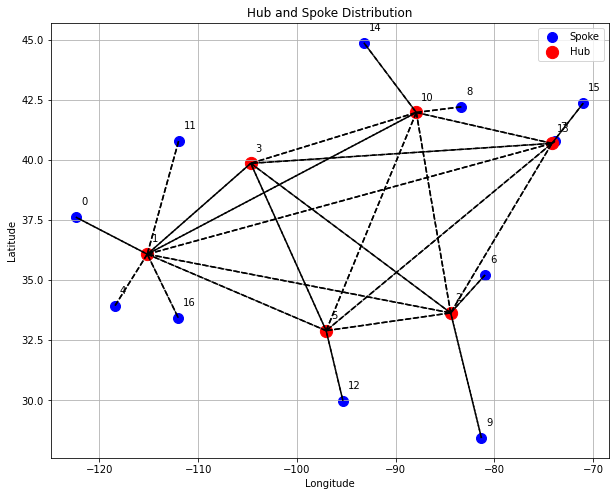

In [ ]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()

## Distances vs. K

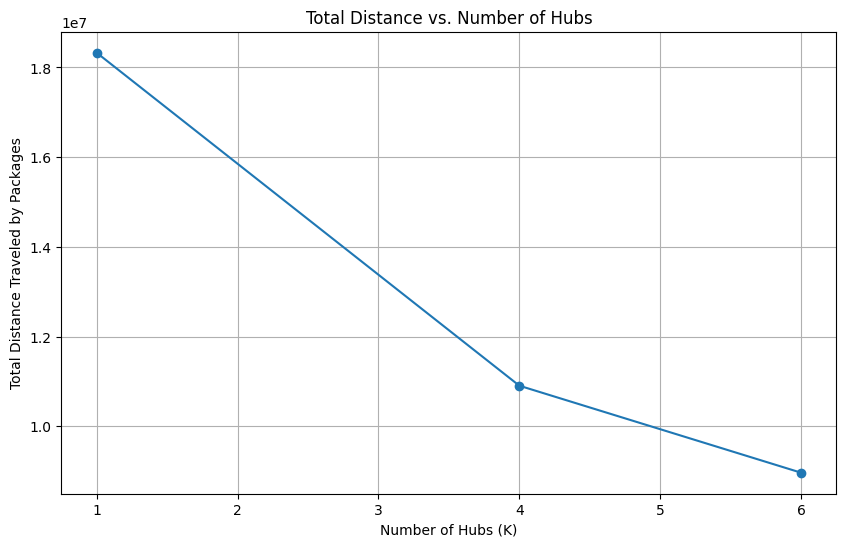

In [2]:
import matplotlib.pyplot as plt
K_values = [1, 4, 6]
total_distances = [18327569.10952155, 10904054.49705949, 8964540.322393237]
plt.figure(figsize=(10,6))
plt.plot(K_values, total_distances, marker='o', linestyle='-')
plt.xlabel("Number of Hubs (K)")
plt.ylabel("Total Distance Traveled by Packages")
plt.title("Total Distance vs. Number of Hubs")
plt.grid(True)
plt.show()

In [11]:
# Initialize model
model = Model("FreshFarm")

N = len(cities_df)

# Decision variables
X = model.addVars(N, vtype=GRB.BINARY, name="x")
Y = model.addVars(N, N, vtype=GRB.BINARY, name="y")
Z = model.addVars(N, N, vtype=GRB.BINARY, name="z")  # Introduced for X[i] * X[j]
W = model.addVars(N, N, N, vtype=GRB.BINARY, name="w") # Introduced for Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj)
U = model.addVars(N, N, N, vtype=GRB.BINARY, name="u") # Introduced for Xi * Xk * Xj
V = model.addVars(N, N, N, N, vtype=GRB.BINARY, name="v")  # Introduced for Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)

# Objective function with alpha = 0.75
alpha = 0.75
K = 6
d = distances
f = packages
M = N

# Objective Function
obj_expr = LinExpr()

# Spoke to hub, hub to hub, hub to spoke
obj_1 = quicksum(Y[i, j] * f[(i, j)] * (d[(i, j)] - Z[i, j] * (1 - alpha) * d[(i, j)]) for i in range(N) for j in range(N) if i != j)

# Spoke-hub-spoke, s-h-h, h-h-s
obj_2 = quicksum(W[i, k, j] * f[(i, j)] * (d[(i, k)] + d[(k, j)] - Z[k, j] * (1 - alpha) * d[(k, j)] - Z[i, k] * (1 - alpha) * d[(i, k)])  
                    for i in range(N) for j in range(N) for k in range(N) if i != k and i != j and k != j)

# s-h-h-s remains unchanged as it doesn't involve direct multiplication of decision variables
obj_3 = quicksum(V[i, m, n, j] * f[(i, j)] * (d[(i, m)] + alpha * d[(m, n)] + d[(n, j)]) 
                    for i in range(N) for j in range(N) for m in range(N) for n in range(N) if i != m and i != n and i != j and m != n and m != j and n != j)

obj_expr = obj_1 + obj_2 + obj_3

model.setObjective(obj_expr, sense=GRB.MINIMIZE)

# Constraints
model.addConstr(quicksum(X[i] for i in range(N)) == K)
for i in range(N):
    model.addConstr(Y[i, i] == 0) # No connnection to itself

    # 1 spoke should only connect to one hub
    model.addConstr(quicksum(Y[i, j] for j in range(N)) <= 1 + M * X[i]) 
    model.addConstr(quicksum(Y[i, j] for j in range(N)) >= 1 - X[i])

    for j in range(N):
        # model.addConstr(Y[i, j] == X[i] * X[j] * (1 - X[i] + X[j]))
        # No connection between spokes, Mush have links between hubs
        # if Xi = Xj = 1, Yij = 1; if Xi = Xj = 0, Yij = 0; Yij = any otherwise
        if i != j:
            model.addConstr(Y[i, j] >= X[i] + X[j] - 1)
            model.addConstr(Y[i, j] <= X[i] + X[j])

        # invertible
        model.addConstr(Y[i, j] == Y[j, i])

        # Zij = Xi * Xj
        model.addConstr(Z[i, j] <= X[i])
        model.addConstr(Z[i, j] <= X[j])
        model.addConstr(Z[i, j] >= X[i] + X[j] - 1)
        for k in range(N):
            # Uikj = Xi * Xk * Xj
            model.addConstr(U[i, k, j] <= X[i])
            model.addConstr(U[i, k, j] <= X[k])
            model.addConstr(U[i, k, j] <= X[j])
            model.addConstr(U[i, k, j] >= X[i] + X[k] + X[j] - 2)

            # Wikj = Y[i, k] * Y[k, j] * (1 - Xi * Xk * Xj) = Y[i, k] * Y[k, j] * (1 - U[i, k, j])
            model.addConstr(W[i, k, j] <= Y[i, k])
            model.addConstr(W[i, k, j] <= Y[k, j])
            model.addConstr(W[i, k, j] <= 1 - U[i, k, j])
            model.addConstr(W[i, k, j] >= Y[i, k] + Y[k, j] + (1 - U[i, k, j]) - 2)

        for m in range(N):
            for n in range(N):

                # Vimnj = Y[i, m] * Y[m, n]  * Y[n, j] * (1 - Xi) * Xm * Xn * (1 - Xj)
                model.addConstr(V[i, m, n, j] <= Y[i, m])
                model.addConstr(V[i, m, n, j] <= Y[m, n])
                model.addConstr(V[i, m, n, j] <= Y[n, j])
                model.addConstr(V[i, m, n, j] <= 1 - X[i])
                model.addConstr(V[i, m, n, j] <= 1 - X[j])
                # model.addConstr(V[i, m, n, j] <= X[m])
                # model.addConstr(V[i, m, n, j] <= X[n])
                model.addConstr(V[i, m, n, j] >= Y[i, m] + Y[m, n] + Y[n, j] + 1 - X[i] + 1 - X[j] - 4)
                

# Optimize the model
model.optimize()

# Print the results
if model.status == GRB.INFEASIBLE:
    print("Model is infeasible")
    model.computeIIS()
    model.write("model.ilp")
    print("IIS written to file 'model.ilp'. Please inspect this file to understand which constraints are conflicting.")

if model.status == GRB.OPTIMAL:
    print("Optimal Solution Found")
    for i in range(N):
        print(f"X[{i}] = {X[i].X}")
    for i in range(N):
        for j in range(N):
            print(f"Y[{i},{j}] = {Y[i, j].X}")
    print("Objective Value:", model.objVal)
else:
    print("Optimal solution not found")

Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (mac64[rosetta2])

CPU model: Apple M2
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 542182 rows, 93942 columns and 1432794 nonzeros
Model fingerprint: 0xbfb91c41
Model has 8153 quadratic objective terms
Variable types: 0 continuous, 93942 integer (93942 binary)
Coefficient statistics:
  Matrix range     [1e+00, 2e+01]
  Objective range  [3e-01, 7e+05]
  QObjective range [2e-01, 2e+05]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 6e+00]
Presolve removed 91368 rows and 14506 columns (presolve time = 5s) ...
Presolve removed 91370 rows and 14506 columns (presolve time = 10s) ...
Presolve removed 462918 rows and 54799 columns (presolve time = 15s) ...
Presolve removed 463542 rows and 54953 columns
Presolve time: 15.52s
Presolved: 86793 rows, 47142 columns, 323374 nonzeros
Variable types: 0 continuous, 47142 integer (47142 binary)
Found heuristic solution: objective 2.79174

  4325  1771 964996.742   26 1161 8978942.25 712617.893  92.1%   149  296s
  4645  1991 1544002.04   30 1029 8978942.25 717480.209  92.0%   145  301s
  4855  2158 1787287.45   42  584 8978942.25 720213.457  92.0%   143  305s
  5409  2356 960030.766   28 1002 8978942.25 728192.059  91.9%   140  312s
  5593  2427 1061547.59   22 1029 8978942.25 728314.596  91.9%   138  315s
  5990  2666 984599.930   27 1194 8978942.25 744909.603  91.7%   136  322s
  6245  2812 7662133.39   33  234 8978942.25 750818.948  91.6%   134  327s
  6566  3028 1025547.48   24 1111 8978942.25 754910.324  91.6%   132  331s
  6917  3171 3612223.25   38  399 8978942.25 757642.848  91.6%   131  341s
  7148  3273 1923719.89   27 1072 8978942.25 761499.243  91.5%   130  345s
  7439  3465 977333.247   25 1196 8978942.25 769254.819  91.4%   129  350s
  8183  3849 1022485.23   30 1051 8978942.25 779001.976  91.3%   127  358s
  8508  4024 1410110.34   25  538 8978942.25 783579.172  91.3%   127  364s
  8852  4110 1867693.60  

 37573 16126 2298818.17   41 1053 8964540.32 945152.360  89.5%   105 1390s
 37953 16267 1990452.70   44  688 8964540.32 945152.360  89.5%   105 1397s
 38513 16303 1005038.95   36 1160 8964540.32 945152.360  89.5%   105 1405s
 38936 16512 2044487.56   49  377 8964540.32 945152.360  89.5%   105 1413s
 39608 16561 1144726.37   44  874 8964540.32 945152.360  89.5%   105 1420s
 40148 16635 6520390.70   39  234 8964540.32 945152.360  89.5%   105 1441s
 40612 16731 978941.444   38 1094 8964540.32 945152.360  89.5%   105 1450s
 41081 16945 3688895.83   48  702 8964540.32 945152.360  89.5%   106 1458s
 41962 17099 1145501.01   38 1064 8964540.32 945152.360  89.5%   106 1468s
 42746 17318 7850290.13   64  234 8964540.32 945152.360  89.5%   105 1477s
 43651 17383 1122762.82   42 1338 8964540.32 945152.360  89.5%   105 1488s
 44291 17764 6627913.48   41  234 8964540.32 945152.360  89.5%   105 1506s
 45435 17570     cutoff   40      8964540.32 945152.360  89.5%   104 1514s
 45948 17866 1071983.64  

 130959 43161 1607268.20   45  542 8964540.32 1290413.74  85.6%  91.3 2322s
 131610 43737 5900147.23   51  399 8964540.32 1293725.18  85.6%  91.3 2339s
 133286 43985 1770971.46   45  536 8964540.32 1299186.94  85.5%  91.2 2345s
 133896 44356     cutoff   59      8964540.32 1302588.95  85.5%  91.1 2352s
 134789 44650 6785685.20   50  238 8964540.32 1306691.31  85.4%  91.0 2357s
 135647 44864 8355150.15   48  232 8964540.32 1309352.15  85.4%  91.0 2363s
 136312 45195 1777842.23   46  349 8964540.32 1311804.71  85.4%  90.9 2368s
 137264 45523 6411244.82   44  226 8964540.32 1315257.77  85.3%  90.8 2374s
 138077 45802 8440383.14   50  228 8964540.32 1319506.47  85.3%  90.7 2380s
 138930 46158 8168146.37   63  242 8964540.32 1322006.99  85.3%  90.6 2386s
 139899 46374 6920858.08   48  234 8964540.32 1325049.34  85.2%  90.5 2392s
 140500 46697 3295030.74   48  388 8964540.32 1327732.57  85.2%  90.5 2398s
 141310 47007 3581933.39   47  566 8964540.32 1331376.72  85.1%  90.4 2404s
 142200 4726

 224074 70981 7355802.78   48  239 8964540.32 1697659.73  81.1%  87.2 3031s
 224738 71212 8197803.02   44  236 8964540.32 1701855.91  81.0%  87.2 3035s
 225661 71501     cutoff   45      8964540.32 1705986.31  81.0%  87.2 3040s
 226661 71723 6574111.52   41  234 8964540.32 1709991.90  80.9%  87.1 3045s
 227441 71948 2911142.62   54  568 8964540.32 1713672.78  80.9%  87.1 3050s
 228350 72099     cutoff   49      8964540.32 1717520.60  80.8%  87.1 3055s
 228925 72338 6519840.11   51  423 8964540.32 1720118.02  80.8%  87.1 3060s
 229916 72573 2828003.08   50  369 8964540.32 1725369.50  80.8%  87.0 3065s
 231861 73020 5959266.82   49  379 8964540.32 1735759.85  80.6%  87.0 3075s
 233490 73491 7162048.75   51  232 8964540.32 1744441.07  80.5%  87.0 3084s
 234376 73600     cutoff   54      8964540.32 1748047.55  80.5%  87.0 3089s
 234969 73732 7128244.71   46  232 8964540.32 1752029.48  80.5%  87.0 3094s
 235894 74081 2489289.41   50  549 8964540.32 1759147.98  80.4%  87.0 3107s
 237170 7429

 318305 88770 3304891.70   55  426 8964540.32 2475031.84  72.4%  88.0 3669s
 319194 88820     cutoff   52      8964540.32 2487259.14  72.3%  88.0 3675s
 319883 88946     cutoff   46      8964540.32 2495930.15  72.2%  88.1 3680s
 320801 89065 7941308.91   49  224 8964540.32 2510213.36  72.0%  88.1 3687s
 321512 89223     cutoff   58      8964540.32 2519187.54  71.9%  88.1 3692s
 322541 89330     cutoff   49      8964540.32 2531028.69  71.8%  88.1 3699s
 323453 89383 8165483.44   48  429 8964540.32 2542621.38  71.6%  88.1 3704s
 324226 89504 2702781.53   46  379 8964540.32 2551780.16  71.5%  88.1 3710s
 325093 89598 7942971.41   58  242 8964540.32 2560289.57  71.4%  88.1 3715s
 325998 89657 8379556.40   53  240 8964540.32 2572133.01  71.3%  88.1 3729s
 326805 89695     cutoff   52      8964540.32 2580902.83  71.2%  88.2 3735s
 327929 89708 7947161.82   63  240 8964540.32 2600039.69  71.0%  88.2 3741s
 328867 89771     cutoff   47      8964540.32 2614597.88  70.8%  88.3 3747s
 329649 8984

 411758 88555     cutoff   56      8964540.32 4192517.03  53.2%  90.1 4289s
 412368 88424     cutoff   70      8964540.32 4209515.10  53.0%  90.1 4294s
 413335 88261 6860574.76   66  238 8964540.32 4238868.48  52.7%  90.1 4298s
 414311 88072     cutoff   37      8964540.32 4270258.54  52.4%  90.1 4303s
 415214 87919     cutoff   55      8964540.32 4298797.31  52.0%  90.2 4308s
 416056 87774     cutoff   60      8964540.32 4328580.35  51.7%  90.2 4313s
 416891 87544 8823749.04   57  227 8964540.32 4360221.40  51.4%  90.2 4318s
 417734 87456 5749243.89   67  411 8964540.32 4393978.08  51.0%  90.2 4323s
 418386 87236     cutoff   55      8964540.32 4409872.14  50.8%  90.2 4328s
 419294 87025     cutoff   53      8964540.32 4450904.41  50.3%  90.2 4333s
 420204 86847     cutoff   65      8964540.32 4492585.52  49.9%  90.2 4338s
 421215 86686 5660356.92   57  407 8964540.32 4524046.86  49.5%  90.2 4343s
 421936 86450 6254503.36   52  420 8964540.32 4553241.61  49.2%  90.2 4347s
 422909 8623

 519595 82956 8270431.36   51  236 8964540.32 6284569.81  29.9%  84.0 4988s
 520373 82944 8635931.97   56  233 8964540.32 6290270.77  29.8%  83.9 4993s
 521298 82912     cutoff   47      8964540.32 6295121.85  29.8%  83.9 4997s
 522130 82872 8110087.67   48  313 8964540.32 6301179.41  29.7%  83.8 5001s
 522945 82842 8819625.10   50  230 8964540.32 6307385.01  29.6%  83.8 5006s
 523787 82840 7825300.68   45  237 8964540.32 6311310.17  29.6%  83.7 5010s
 524992 82819     cutoff   47      8964540.32 6316445.06  29.5%  83.6 5015s
 526490 82803 7919039.70   41  237 8964540.32 6325392.94  29.4%  83.6 5031s
 527919 82780 8136775.88   60  239 8964540.32 6333616.84  29.3%  83.5 5036s
 528720 82788 7842639.86   61  233 8964540.32 6338377.24  29.3%  83.4 5040s
 530470 82727 8498992.05   48  234 8964540.32 6349346.52  29.2%  83.3 5049s
 531323 82697     cutoff   48      8964540.32 6355225.80  29.1%  83.3 5053s
 532172 82655 6839967.77   49  239 8964540.32 6359727.24  29.1%  83.2 5057s
 532998 8263

 619039 76042 8647081.75   41  238 8964540.32 6840238.56  23.7%  79.3 5537s
 619868 75927 8453231.55   44  272 8964540.32 6846333.05  23.6%  79.3 5542s
 620606 75827 8233086.89   57  229 8964540.32 6850461.08  23.6%  79.2 5546s
 621534 75718 8304318.51   61  234 8964540.32 6857039.20  23.5%  79.2 5551s
 622397 75624     cutoff   44      8964540.32 6862650.34  23.4%  79.2 5556s
 623232 75504 8387731.45   59  230 8964540.32 6867740.59  23.4%  79.1 5561s
 624102 75408 8443810.35   47  232 8964540.32 6872549.87  23.3%  79.1 5566s
 624950 75277 8631424.79   52  228 8964540.32 6878062.15  23.3%  79.1 5570s
 625731 75167 7348894.85   52  268 8964540.32 6884411.45  23.2%  79.1 5575s
 626588 75034 8599406.84   48  238 8964540.32 6889249.59  23.1%  79.0 5581s
 627310 74928 8690618.28   62  242 8964540.32 6894630.50  23.1%  79.0 5586s
 628147 74795     cutoff   55      8964540.32 6900163.89  23.0%  79.0 5591s
 628972 74706 8140990.55   51  236 8964540.32 6905689.29  23.0%  79.0 5595s
 629939 7460

H707695 56384                    8964537.5934 7553598.97  15.7%  76.6 6092s
 708249 56102     cutoff   60      8964537.59 7561567.26  15.7%  76.6 6097s
H708351 56102                    8964537.2542 7561869.90  15.6%  76.6 6097s
H708685 56102                    8964536.3761 7562020.43  15.6%  76.6 6097s
 709120 55815 infeasible   61      8964536.38 7569300.61  15.6%  76.6 6103s
H709320 55815                    8964536.0365 7569342.64  15.6%  76.6 6103s
 709809 55514     cutoff   59      8964536.04 7576236.35  15.5%  76.6 6108s
H710116 55514                    8964535.8645 7576836.67  15.5%  76.6 6108s
 710623 55193     cutoff   47      8964535.86 7584410.35  15.4%  76.6 6114s
 711530 54876     cutoff   57      8964535.86 7593035.14  15.3%  76.6 6119s
 712332 54517 infeasible   59      8964535.86 7602785.13  15.2%  76.5 6124s
 713115 54224     cutoff   55      8964535.86 7610959.95  15.1%  76.5 6130s
 714000 53933     cutoff   62      8964535.86 7619639.23  15.0%  76.5 6135s
 714941 5365

Optimal Solution Found
X[0] = 0.0
X[1] = 1.0
X[2] = 1.0
X[3] = 1.0
X[4] = 0.0
X[5] = 1.0
X[6] = 0.0
X[7] = 0.0
X[8] = 0.0
X[9] = 0.0
X[10] = 1.0
X[11] = 0.0
X[12] = 0.0
X[13] = 1.0
X[14] = 0.0
X[15] = 0.0
X[16] = 0.0
Y[0,0] = 0.0
Y[0,1] = 1.0
Y[0,2] = 0.0
Y[0,3] = 0.0
Y[0,4] = 0.0
Y[0,5] = 0.0
Y[0,6] = 0.0
Y[0,7] = 0.0
Y[0,8] = 0.0
Y[0,9] = 0.0
Y[0,10] = 0.0
Y[0,11] = 0.0
Y[0,12] = 0.0
Y[0,13] = 0.0
Y[0,14] = 0.0
Y[0,15] = 0.0
Y[0,16] = 0.0
Y[1,0] = 1.0
Y[1,1] = 0.0
Y[1,2] = 1.0
Y[1,3] = 1.0
Y[1,4] = 1.0
Y[1,5] = 1.0
Y[1,6] = 0.0
Y[1,7] = 0.0
Y[1,8] = 0.0
Y[1,9] = 0.0
Y[1,10] = 1.0
Y[1,11] = 1.0
Y[1,12] = 0.0
Y[1,13] = 1.0
Y[1,14] = 0.0
Y[1,15] = 0.0
Y[1,16] = 1.0
Y[2,0] = 0.0
Y[2,1] = 1.0
Y[2,2] = 0.0
Y[2,3] = 1.0
Y[2,4] = 0.0
Y[2,5] = 1.0
Y[2,6] = 1.0
Y[2,7] = 0.0
Y[2,8] = 0.0
Y[2,9] = 1.0
Y[2,10] = 1.0
Y[2,11] = 0.0
Y[2,12] = 0.0
Y[2,13] = 1.0
Y[2,14] = 0.0
Y[2,15] = 0.0
Y[2,16] = 0.0
Y[3,0] = 0.0
Y[3,1] = 1.0
Y[3,2] = 1.0
Y[3,3] = 0.0
Y[3,4] = 0.0
Y[3,5] = 1.0
Y[3,6] = 0.0
Y[3,7] =

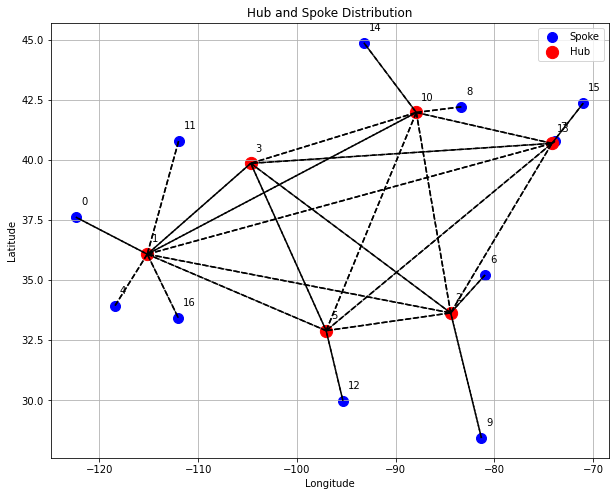

In [12]:
import matplotlib.pyplot as plt

# Extract the data
cities = cities_df[['lat', 'lon']].values
hub_cities = [i for i in range(N) if X[i].X > 0.5]  # Cities where x[i] is 1

# Plot
plt.figure(figsize=(10, 8))
hub_label_added = False
spoke_label_added = False

for i in range(N):
    if i in hub_cities:
        if not hub_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150, label='Hub')  
            hub_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='red', s=150)  
    else:
        if not spoke_label_added:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100, label='Spoke')  
            spoke_label_added = True
        else:
            plt.scatter(cities[i][1], cities[i][0], c='blue', s=100)  

    for j in range(N):
        if Y[i, j].X > 0.5:  # If there is a link through hub k
            plt.plot([cities[i][1], cities[j][1]], [cities[i][0], cities[j][0]], 'k--')

for i, row in cities_df.iterrows():
        plt.text(row['lon'] + 0.5, row['lat'] + 0.5, str(int(row['id'])))

plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Hub and Spoke Distribution')
plt.legend()
plt.grid(True)
plt.show()